Multi-fidelity Modeling and Experimental Design (Active Learning)

In [1]:
# General imports
import numpy as np
np.random.seed(20)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import sys
import os
sys.path.append('../utilities')
import simulation_utils as sim
import plotting_utils as plotting
import drawing_utils as draw_mfsm
import multi_fidelity_surrogate_model as mfsm
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

In [2]:
version = 'v1.6'
file_in=f'Ge77_rates_CNP_{version}.csv'
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')
if not os.path.exists(f'in/Ge77_rates_new_samples_{version}.csv'):
   fout = open(f'in/Ge77_rates_new_samples_{version}.csv')
   fout.write("#\n ,Sample,Mode,Radius[cm],Thickness[cm],NPanels,Theta[deg],Length[cm],Ge-77[nevents],Ge-77_CNP,Ge-77_CNP_err")
   fout.close()
   

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels=['Radius[cm]','Thickness[cm]','NPanels', 'Theta[deg]', 'Length[cm]']
x_labels_out = ['Radius [cm]','Thickness [cm]','NPanels', 'Angle [deg]', 'Length [cm]']
y_label_cnp = 'Ge-77_CNP'
y_err_label_cnp = 'Ge-77_CNP_err'
y_label_sim = 'rGe77[nuc/(kg*yr)]'

# Set parameter boundaries
xmin=[0,0,0,0,0]
xmax=[265,20,360,90,150]

# Set parameter boundaries for aquisition function
xlow=[90,2,4,0,1]
xhigh=[250,15,360,90,150]

# Assign costs
low_fidelity_cost = 1.
high_fidelity_cost = 2000.

# Set a fixed point in space for drawings
x_fixed = [160, 2, 40, 45, 20]
# number of sigma for error band drawing on prediction
factor=1.

# Get LF noise from file
#with open(f'in/{file_in}') as f:
#    first_line = f.readline()
#LF_noise=np.round(float(first_line.split(' +')[0].split('= ')[1]),3)

# Get HF and LF data samples from file

data=pd.read_csv(f'in/{file_in}')
#data=data[[f'Mode', x_labels[0], x_labels[1], x_labels[2], x_labels[3], x_labels[4],y_label_cnp,y_err_label_cnp,y_label_sim]]

LF_noise=np.mean(data.loc[data['Mode']==0.][y_err_label_cnp].to_numpy())
HF_noise=np.mean(data.loc[data['Mode']==1.][y_err_label_cnp].to_numpy())

In [3]:

#data.plot(kind='scatter', x=x_labels[2], y=x_labels[3], alpha=0.4, s=data[x_labels[4]]*2, label='Ge-77',
#figsize=(12, 8), c=y_label, cmap=plt.get_cmap('jet'), colorbar=True)
#plt.legend()
#plt.show()

In [4]:

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
row_h=data.index[data['Mode'] == 1].tolist()
row_l=data.index[data['Mode'] == 0].tolist()

x_train_hf_sim = data.loc[data['Mode']==1.][x_labels].to_numpy().tolist()
y_train_hf_sim = data.loc[data['Mode']==1.][y_label_sim].to_numpy().tolist()

x_train_hf_cnp = data.loc[data['Mode']==1.][x_labels].to_numpy().tolist()
y_train_hf_cnp = data.loc[data['Mode']==1.][ y_label_cnp].to_numpy().tolist()

x_train_lf_sim = data.loc[data['Mode']==0.][x_labels].to_numpy().tolist()
y_train_lf_sim = data.loc[data['Mode']==0.][ y_label_sim].to_numpy().tolist()

x_train_lf_cnp = data.loc[data['Mode']==0.][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[data['Mode']==0.][ y_label_cnp].to_numpy().tolist()

x_train_lf_cnp, x_train_hf_cnp, x_train_hf_sim, y_train_lf_cnp, y_train_hf_cnp, y_train_hf_sim = (np.atleast_2d(x_train_lf_cnp), np.atleast_2d(x_train_hf_cnp), np.atleast_2d(x_train_hf_cnp), np.atleast_2d(y_train_lf_cnp).T, np.atleast_2d(y_train_hf_cnp).T, np.atleast_2d(y_train_hf_sim).T)



In [5]:
mf_model = mfsm.linear_multi_fidelity_model(x_train_lf_cnp, y_train_lf_cnp, LF_noise, x_train_hf_cnp, y_train_hf_cnp, HF_noise, x_train_hf_sim, y_train_hf_sim)

 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/100, f = -288.9164160047447
Warning - optimization restart 2/100 failed
Warning - optimization restart 3/100 failed
Warning - optimization restart 4/100 failed
Warning - optimization restart 5/100 failed
Warning - optimization restart 6/100 failed
Warning - optimization restart 7/100 failed
Warning - optimization restart 8/100 failed
Warning - optimization restart 9/100 failed
Warning - optimization restart 10/100 failed
Warning - optimization restart 11/100 failed
Warning - optimization restart 12/100 failed
Warning - optimization restart 13/100 failed
Warning - optimization restart 14/100 failed
Warning - optimization restart 15/100 failed
Warning - optimization restart 16/100 failed
Warning - optimization restart 17/100 failed
Warning - optimization restart 18/100 failed
Warning - optimization restart 19/100 failed
Warning - optimization restart 20/100 failed
Warning - optimization restart 21/100 failed
Warning - optimization restart 22/100 failed
Warning - op

 /Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


In [6]:
%%capture
leg_label = []
ncol=1
nrow=int(np.ceil(len(x_labels)/ncol))
fig1,ax1  = plt.subplots(2,3, figsize=(15, 5),layout="constrained")
fig2,ax2  = plt.subplots(nrow,ncol, figsize=(5, 12),layout="constrained")

In [7]:
add_new_sample=True
sample=0
total_samples=20

Sample # 0


 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_16944/4204650030.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


next suggested point to simulated is at: [[183.77687221   5.10928197 218.56462547  48.95161503  19.76241976
    1.        ]]


 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:69: RuntimeWarning:invalid value encountered in divide
 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:49: RuntimeWarning:invalid value encountered in divide


Sample # 1
Adding LF sample at [183.8, 5.1, 219.0, 49.0, 19.8] with Ge-77_CNP of [0.2846]
Adding HF sample at [183.8, 5.1, 219.0, 49.0, 19.8] with Ge-77_CNP of [0.1634]
Adding HF sample at [183.8, 5.1, 219.0, 49.0, 19.8] with rGe77[nuc/(kg*yr)] of [0.1447]


 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_16944/4204650030.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


next suggested point to simulated is at: [[184.17824505   5.09433999 218.16346501  48.88959007  17.77132957
    1.        ]]


 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:69: RuntimeWarning:invalid value encountered in divide
 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:49: RuntimeWarning:invalid value encountered in divide


Sample # 2
Adding LF sample at [184.2, 5.1, 218.0, 48.9, 17.8] with Ge-77_CNP of [0.2787]
Adding HF sample at [184.2, 5.1, 218.0, 48.9, 17.8] with Ge-77_CNP of [0.1632]
Adding HF sample at [184.2, 5.1, 218.0, 48.9, 17.8] with rGe77[nuc/(kg*yr)] of [0.1671]


 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_16944/4204650030.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


next suggested point to simulated is at: [[202.42309702   2.65217688  29.3170381   10.41439995  78.7468458
    1.        ]]


 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:69: RuntimeWarning:invalid value encountered in divide
 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:49: RuntimeWarning:invalid value encountered in divide


Sample # 3
Adding LF sample at [202.4, 2.7, 29.0, 10.4, 78.7] with Ge-77_CNP of [0.1637]
Adding HF sample at [202.4, 2.7, 29.0, 10.4, 78.7] with Ge-77_CNP of [0.1305]
Adding HF sample at [202.4, 2.7, 29.0, 10.4, 78.7] with rGe77[nuc/(kg*yr)] of [0.1939]


 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_16944/4204650030.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


next suggested point to simulated is at: [[208.36292379   4.29873558  17.61187394   3.03344293  50.63781836
    1.        ]]


 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:69: RuntimeWarning:invalid value encountered in divide
 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:49: RuntimeWarning:invalid value encountered in divide


Sample # 4
Adding LF sample at [208.4, 4.3, 18.0, 3.0, 50.6] with Ge-77_CNP of [0.1516]
Adding HF sample at [208.4, 4.3, 18.0, 3.0, 50.6] with Ge-77_CNP of [0.13]
Adding HF sample at [208.4, 4.3, 18.0, 3.0, 50.6] with rGe77[nuc/(kg*yr)] of [0.1897]


 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_16944/4204650030.py:12: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


next suggested point to simulated is at: [[2.25176415e+02 9.57348192e+00 7.07050446e+00 4.31501129e-02
  3.54871520e+00 1.00000000e+00]]


 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:69: RuntimeWarning:invalid value encountered in divide
 /Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/multi-fidelity-gaussian-process/../utilities/plotting_utils.py:49: RuntimeWarning:invalid value encountered in divide


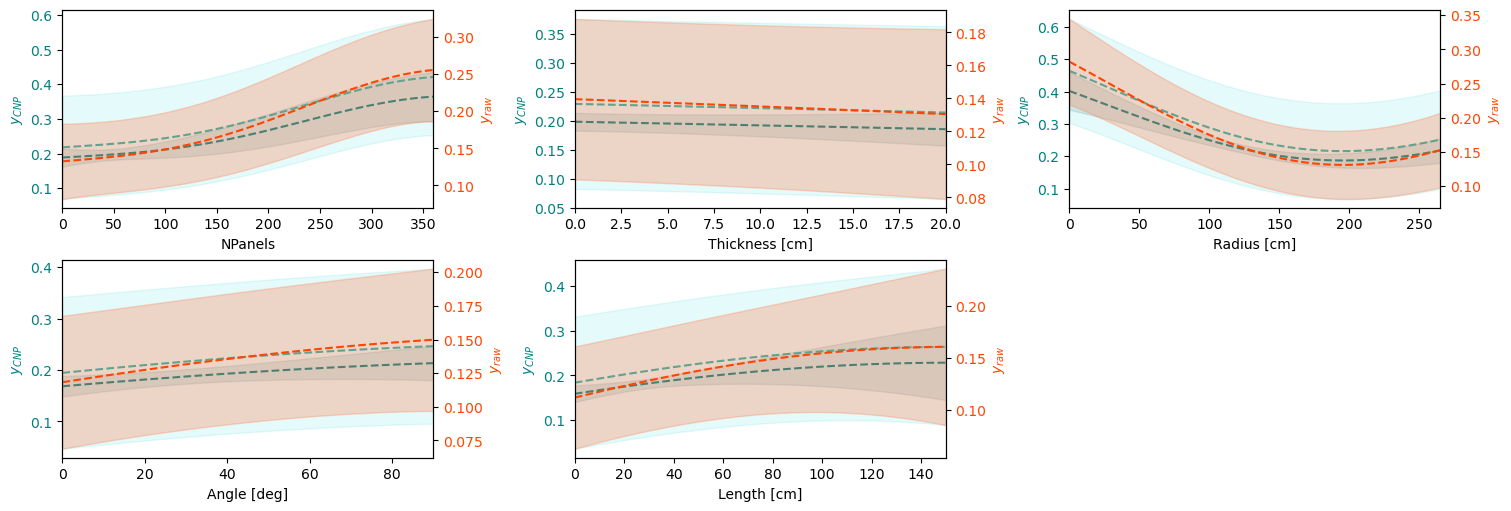

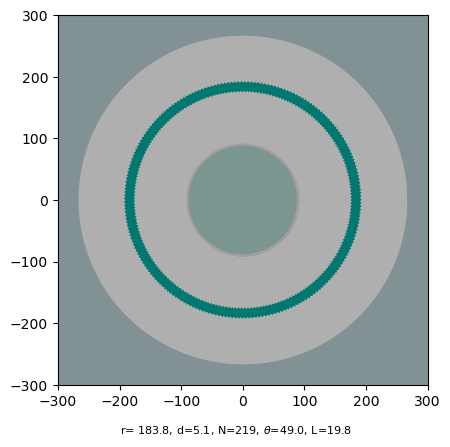

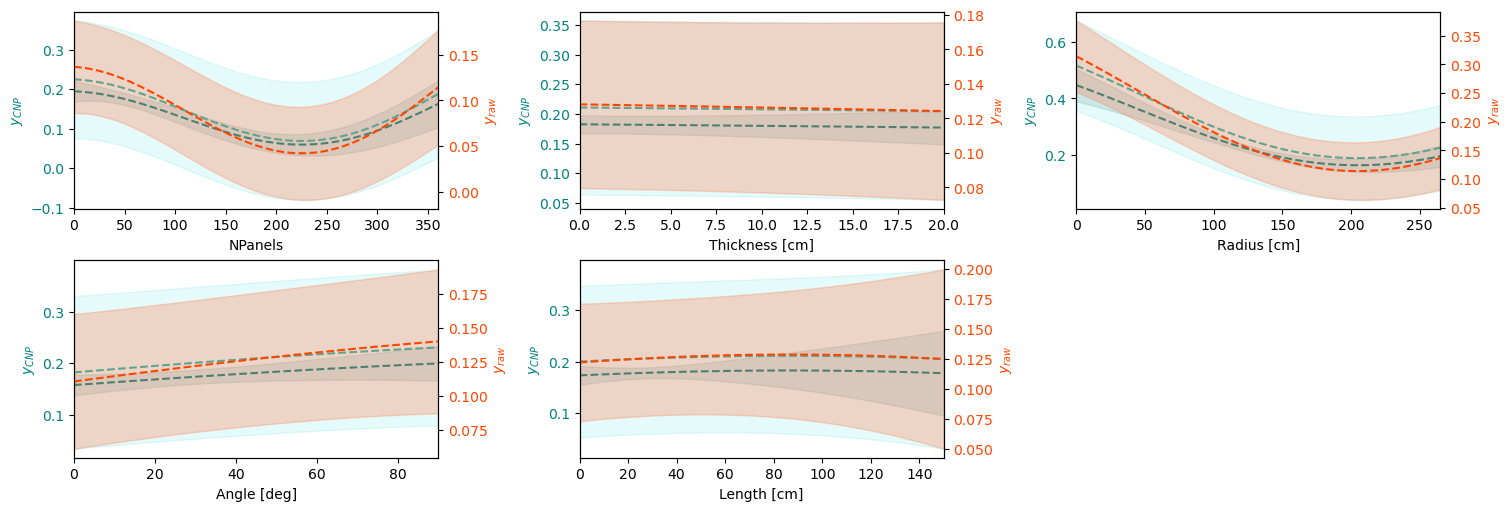

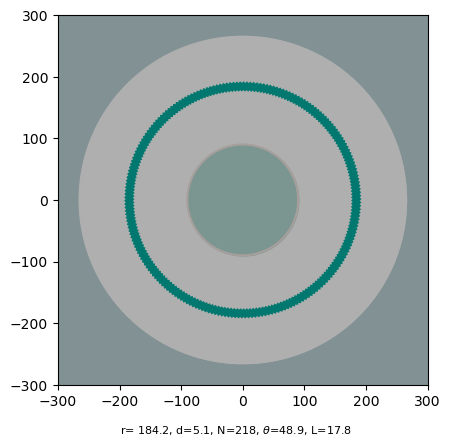

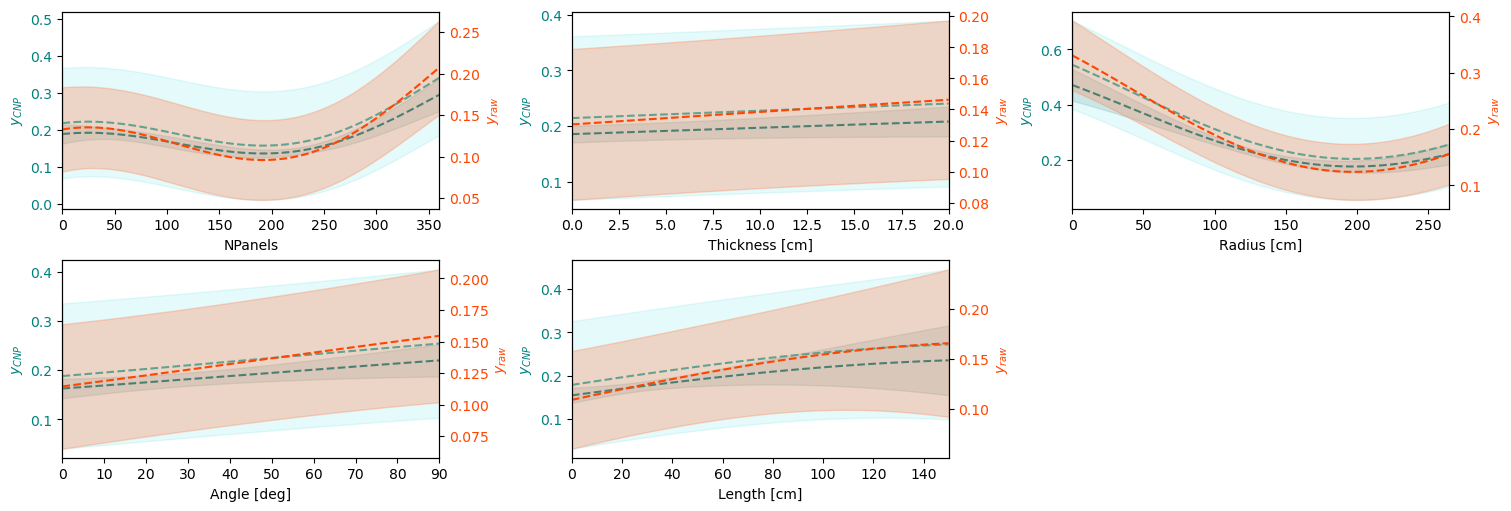

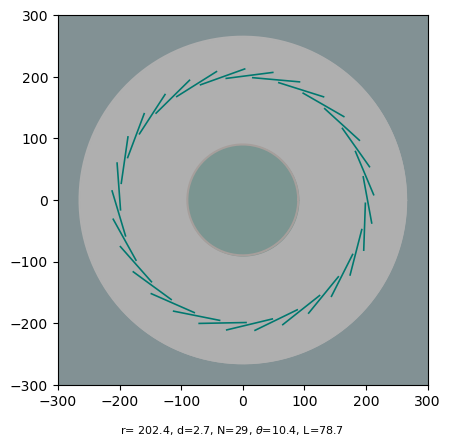

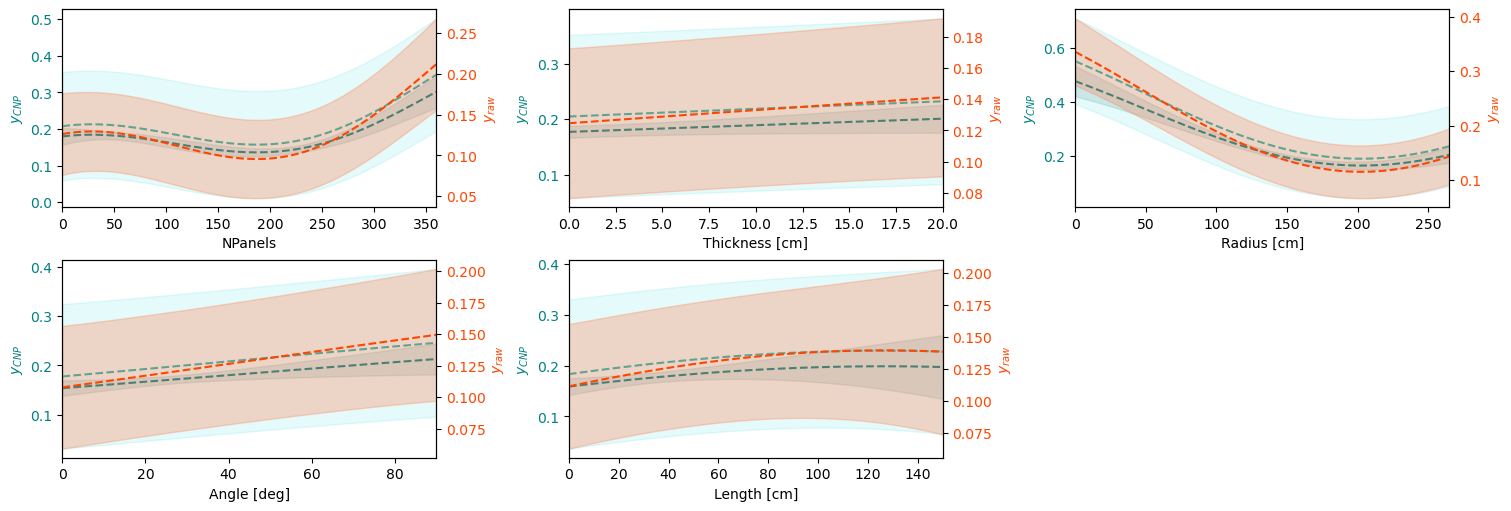

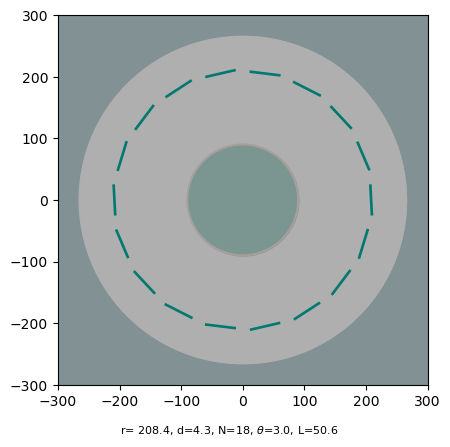

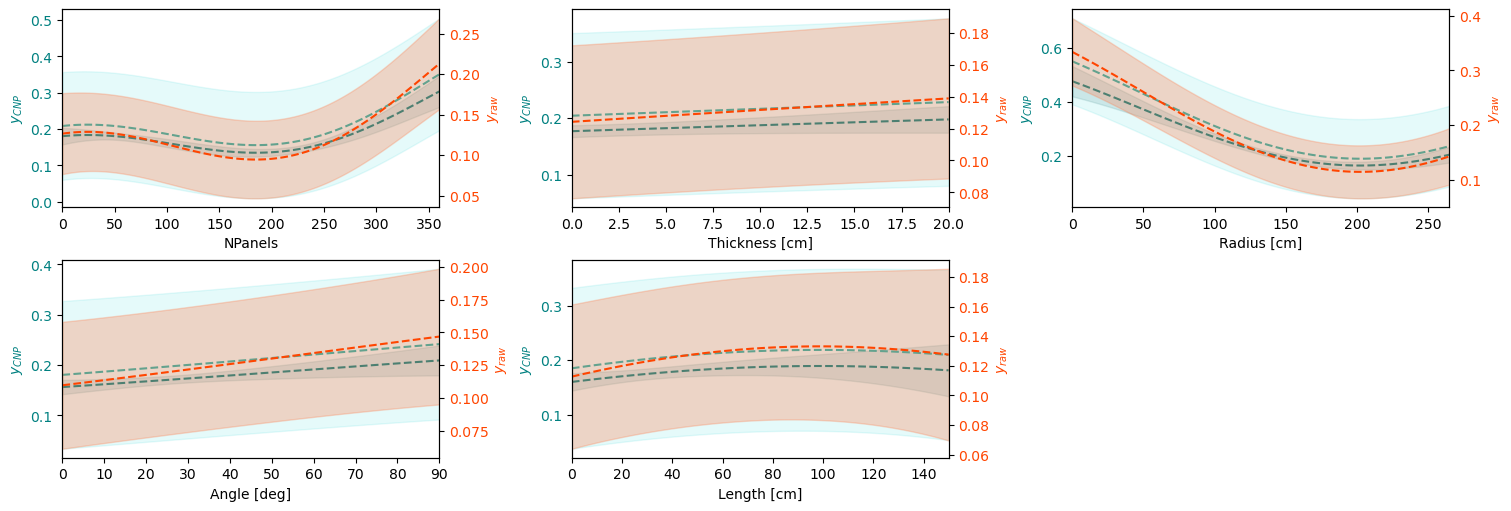

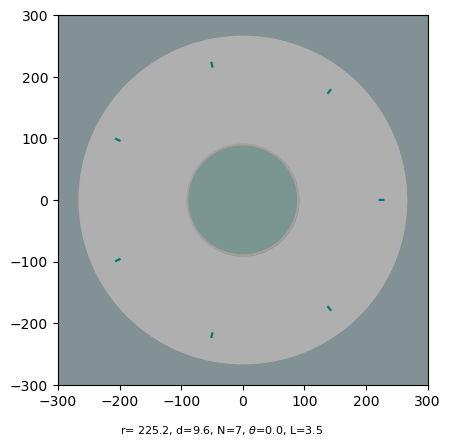

In [8]:

while ( sample < total_samples and sample <= max(mfsm.get_num_new_samples(version)[0],mfsm.get_num_new_samples(version)[1])+1 ):
    print('Sample #', sample)
    # add new data point to training data and update model with new training data
    x_new_data=np.array([])
    y_new_data_h=np.array([])
    if sample > 0:
        x_train_lf_cnp, y_train_lf_cnp, x_train_hf_cnp, y_train_hf_cnp, x_train_hf_sim, y_train_hf_sim, mf_model = mfsm.add_samples(x_train_lf_cnp, y_train_lf_cnp, x_train_hf_cnp, y_train_hf_cnp, x_train_hf_sim, y_train_hf_sim, mf_model, x_labels, [y_label_cnp, y_label_sim] ,sample-1, version)

    # run the model drawing
    draw_mfsm.draw_model(mf_model, xmin, xmax, x_labels_out, factor, version)#
    fig1 = draw_mfsm.draw_model_updated(fig1, mf_model, xmin, xmax, x_labels_out, factor, version, x_fixed=x_fixed)
    fig1.show()
    fig1.savefig("update.png")

    # find the next data point
    x_next_sample, us_acquisition = mfsm.max_acquisition_integrated_variance_reduction(mf_model, xlow, xhigh, x_labels)
    print(f'next suggested point to simulated is at: {x_next_sample}')
    sim.print_geant4_macro(x_next_sample[0],f"n{sample}",mode="LF",version=version)
    sim.print_geant4_macro(x_next_sample[0],f"n{sample}",mode="HF",version=version)
    plotting.draw_moderator_config(x_next_sample[0][0],x_next_sample[0][1],x_next_sample[0][2],x_next_sample[0][3],x_next_sample[0][4])
    fig2 = draw_mfsm.draw_acquisition_func(fig2, us_acquisition, xlow, xhigh, x_labels_out, np.array(x_next_sample), version, x_fixed=x_fixed)
    xi =x_next_sample[0,:-1]

    sample+=1




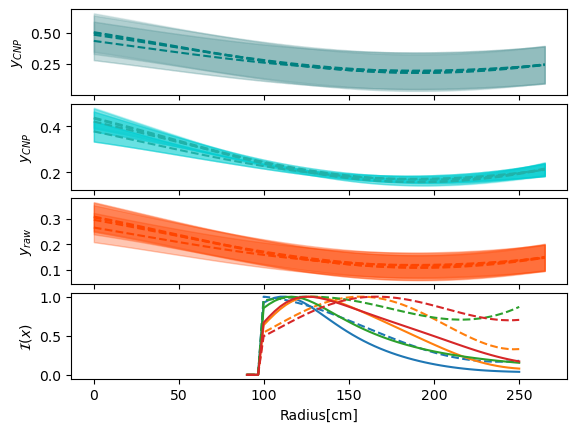

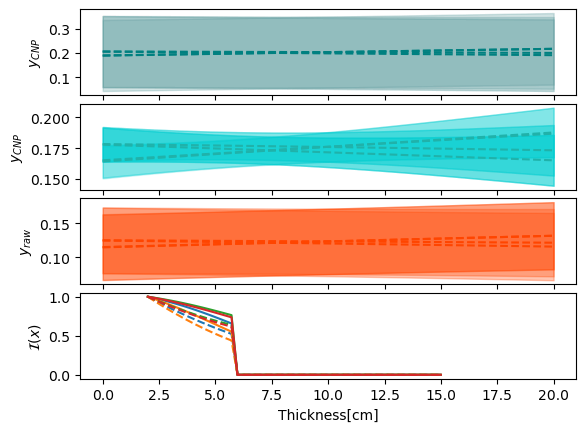

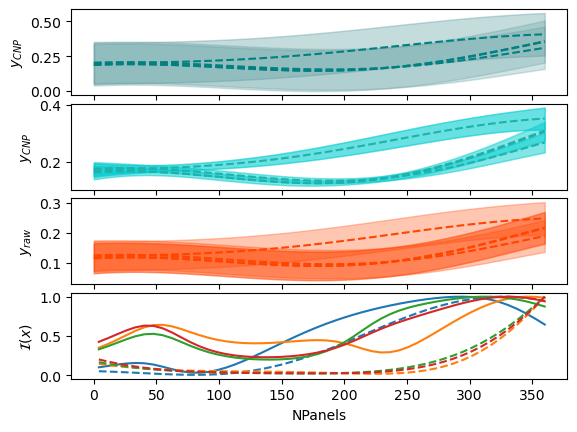

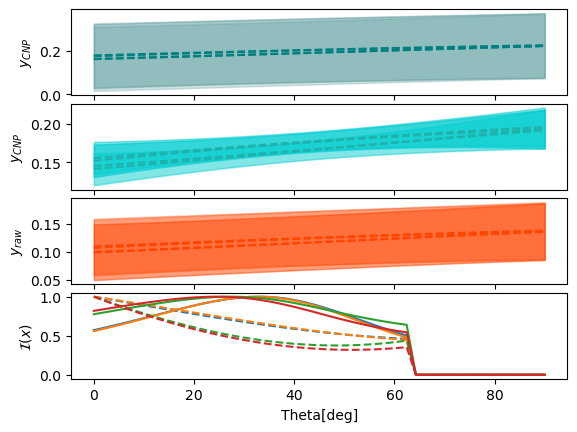

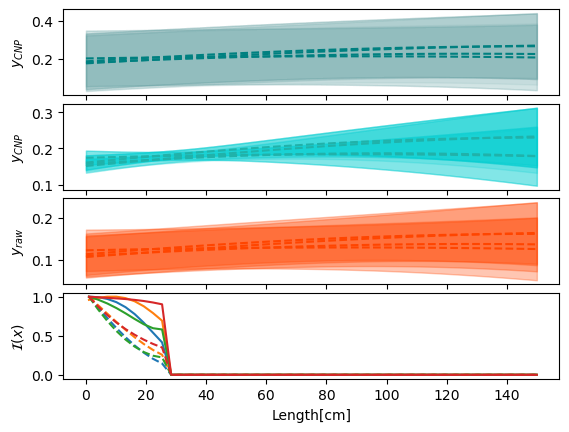

In [9]:
draw_mfsm.draw_model_acquisition_func(fig1,fig2,x_labels,version)

In [21]:

def model_validation(mf_model, file_in, x_labels, y_label, version):
        data=pd.read_csv(file_in)
        #data=data[[f'Mode', x_labels[0], x_labels[1], x_labels[2], x_labels[3], x_labels[4],y_label]]

        x_train_hf_sim = data.loc[data['Mode']==1.][x_labels].to_numpy().tolist()
        y_train_hf_sim = data.loc[data['Mode']==1.][y_label].to_numpy().tolist()
        x_train_hf_sim, y_train_hf_sim = (np.atleast_2d(x_train_hf_sim), np.atleast_2d(y_train_hf_sim).T)

        counter_1sigma = 0
        counter_2sigma = 0
        counter_3sigma = 0

        mfsm_model_mean = np.empty(shape=[0, 0])
        mfsm_model_std = np.empty(shape=[0, 0])
        hf_data=[]
        x=[]
        for i in range(len(x_train_hf_sim)):

                SPLIT = 1
                x_plot = (np.atleast_2d(x_train_hf_sim[i]))
                X_plot = convert_x_list_to_array([x_plot , x_plot, x_plot])
                hhf_mean_mf_model, hhf_var_mf_model = mf_model.predict(X_plot[2*SPLIT:])
                hhf_std_mf_model = np.sqrt(hhf_var_mf_model)

                hf_data.append(y_train_hf_sim[i])
                x.append(i)
                mfsm_model_mean=np.append(mfsm_model_mean,hhf_mean_mf_model[0,0])
                mfsm_model_std=np.append(mfsm_model_std,hhf_std_mf_model[0,0])
                if (y_train_hf_sim[i] < hhf_mean_mf_model+hhf_std_mf_model) and (y_train_hf_sim[i] > hhf_mean_mf_model-hhf_std_mf_model):
                        counter_1sigma += 1
                if (y_train_hf_sim[i] < hhf_mean_mf_model+2*hhf_std_mf_model) and (y_train_hf_sim[i] > hhf_mean_mf_model-2*hhf_std_mf_model):
                        counter_2sigma += 1
                if (y_train_hf_sim[i] < hhf_mean_mf_model+3*hhf_std_mf_model) and (y_train_hf_sim[i] > hhf_mean_mf_model-3*hhf_std_mf_model):
                        counter_3sigma += 1

        print("1 sigma: ", counter_1sigma/len(hf_data)*100.," %" )
        print("2 sigma: ", counter_2sigma/len(hf_data)*100.," %" )
        print("3 sigma: ", counter_3sigma/len(hf_data)*100.," %" )

        fig = plt.subplots(figsize=(12, 2.5))
        #plt.bar(x=np.arange(len(mfsm_model_mean)), height=mfsm_model_mean, color="lightgray", label='RESuM')
        plt.fill_between(x=np.arange(len(mfsm_model_mean)), y1=mfsm_model_mean-3*mfsm_model_std, y2=mfsm_model_mean+3*mfsm_model_std, color="coral",alpha=0.2, label=r'$\pm 3\sigma$')
        plt.fill_between(x=np.arange(len(mfsm_model_mean)), y1=mfsm_model_mean-2*mfsm_model_std, y2=mfsm_model_mean+2*mfsm_model_std, color="yellow",alpha=0.2, label=r'$\pm 2\sigma$')
        plt.fill_between(x=np.arange(len(mfsm_model_mean)), y1=mfsm_model_mean-mfsm_model_std, y2=mfsm_model_mean+mfsm_model_std, color="green",alpha=0.2, label=r'RESuM $\pm 1\sigma$')
        plt.xlabel('HF Simulation Trial Number')
        plt.ylim(0.,0.55)
        plt.ylabel(r'$y_{raw}$')
        plt.plot(x[:],hf_data[:],'.',color="black", label="HF Validation Data")
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [3,2,1,0]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=9, bbox_to_anchor=(0.665,1.),ncol=5)
        plt.savefig(f'out/{version}/model-validation_{version}.pdf')
        return fig

1 sigma:  62.0  %
2 sigma:  95.0  %
3 sigma:  99.0  %
100


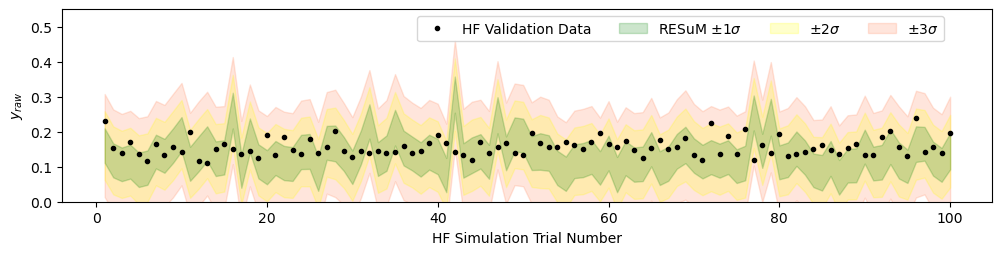

In [22]:
fig = model_validation(mf_model,"in/hf_validation_data_v1.2.csv",x_labels, y_label_sim, version)
plt.show()


minimum found at [186.60049344586577, 8.519548221291817, 180, 20.134823843338488, 7.457625615805366] with f = 0.07987069185757623 and a reduction of 2.9798181811912263
minimum found at [173.49192633212786, 3.28264732732786, 153, 1.2938694595023725, 6.492935659840428] with f = 0.05696120690943651 and a reduction of 4.178284707343503
minimum found at [174.67878312102783, 12.441510255813578, 157, 1.7211259352817765, 1.892129186086492] with f = 0.07032621679104922 and a reduction of 3.384230669604556
minimum found at [163.10038982473685, 14.851721874846051, 201, 13.187241021939997, 4.559234972059633] with f = 0.07936554875989454 and a reduction of 2.9987840248109676
minimum found at [208.75630884133204, 3.9087257546489727, 134, 8.541453701500147, 12.403322455877658] with f = 0.07819815562063903 and a reduction of 3.0435518312750554
minimum found at [142.85343464903303, 8.050876984707276, 136, 16.16040025285766, 3.666855139200756] with f = 0.08834187609573796 and a reduction of 2.6940806586

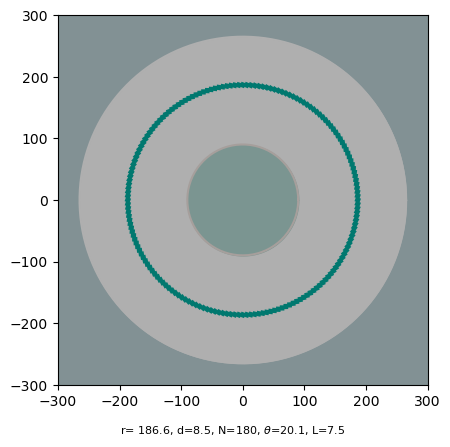

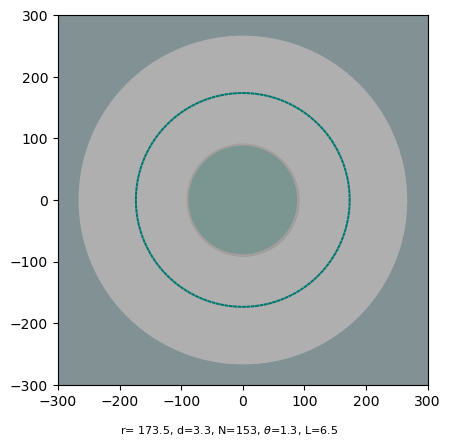

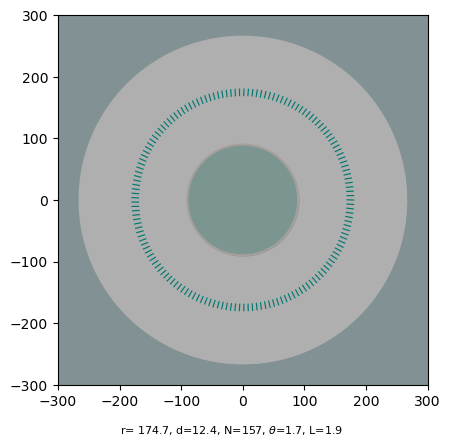

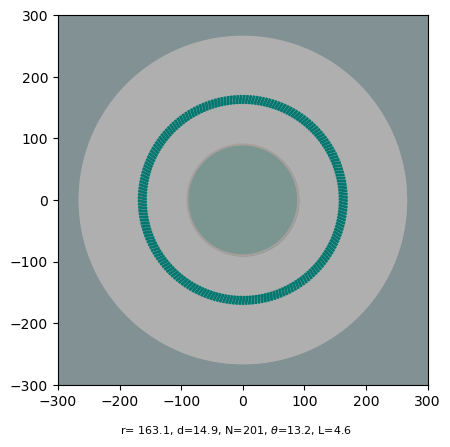

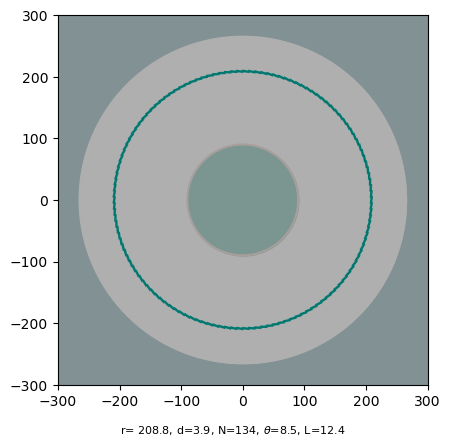

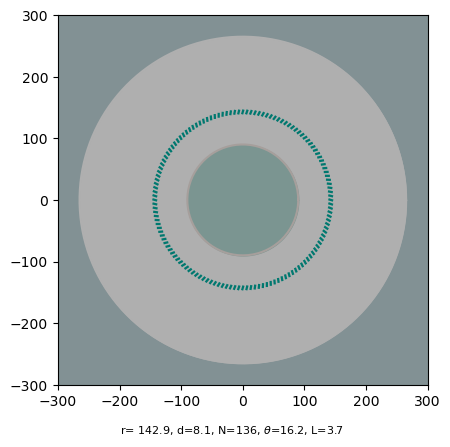

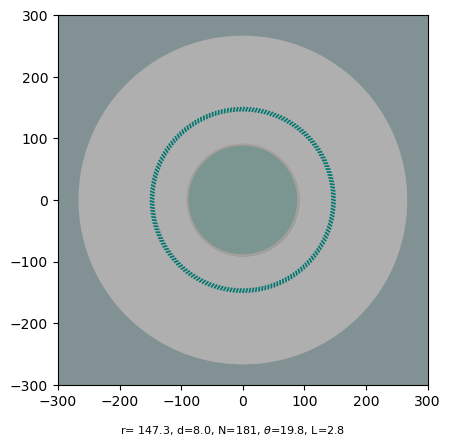

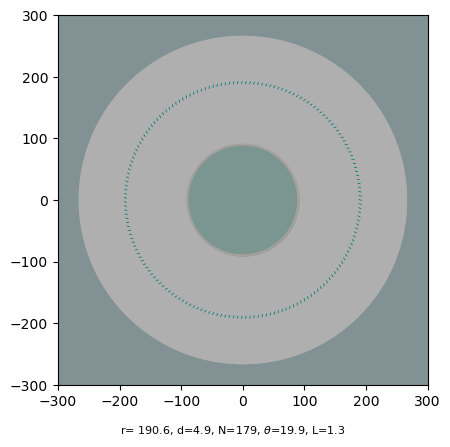

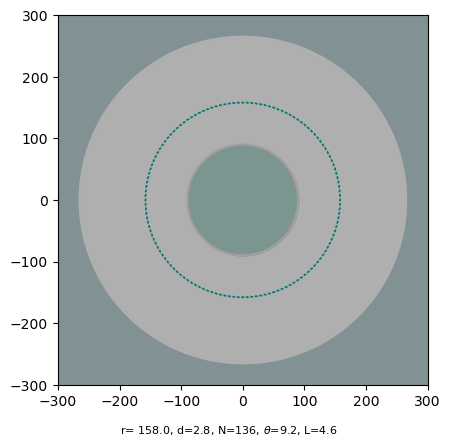

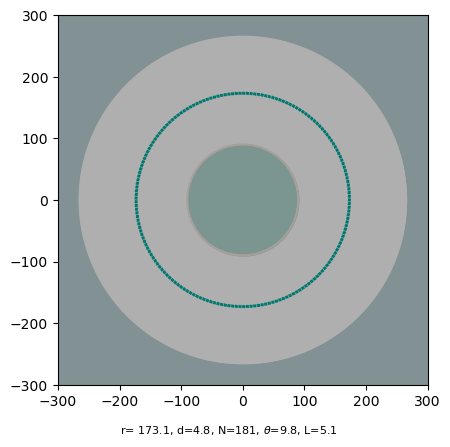

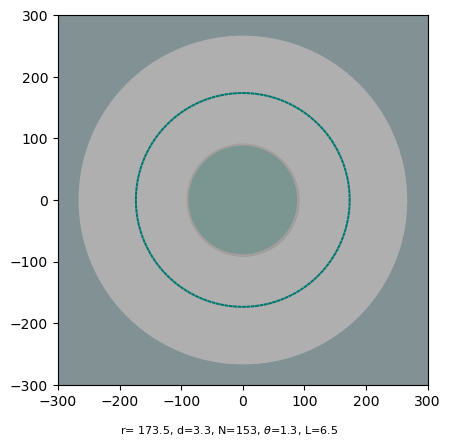

In [11]:
pdf=PdfPages(f'out/{version}/model-min_{version}.pdf')
x_fmin = [150,10,360,0,3]
f_min = 1.
for i in range(10):
    x_fmin_tmp, f_min_tmp = mfsm.get_min_constrained(mf_model, xlow, xhigh, x_labels)
    plotting.draw_moderator_configuration(x_fmin_tmp)
    #pdf.savefig()
    print(f"minimum found at {x_fmin_tmp} with f = {f_min_tmp} and a reduction of {mfsm.evaluate_model([0.,0.,0.,0.,0.],mf_model,2)/f_min_tmp}")
    #draw_mfsm.draw_model(mf_model, xmin, xmax, x_labels_out, factor, version,x_fixed=x_fmin_tmp)#
    #pdf.savefig()
    if f_min_tmp <= f_min:
        x_fmin = x_fmin_tmp
        f_min = f_min_tmp
    #if i % 10 ==0:
    #    print(i,f"*** minimum found at {x_fmin} with f = {f_min} and a reduction of {y_train_hf_sim[0][0]/f_min}")
    #    plotting.draw_moderator_configuration(x_fmin)
    #    pdf.savefig()
    itmp=201+i
    sim.print_geant4_macro(x_fmin_tmp,f"{itmp}",mode="LF",version=f"{version}")

pdf.close()

print(f"minimum found at {x_fmin} with f = {f_min} and a reduction of {mfsm.evaluate_model([0.,0.,0.,0.,0.], mf_model,2)/f_min}")
print("high fidelity", mfsm.evaluate_model(x_fmin, mf_model,2), mfsm.evaluate_model([x_fmin[0],plotting.get_outer_radius(x_fmin)-plotting.get_inner_radius(x_fmin),360,0.,4.],mf_model,2))
print("medium fidelity", mfsm.evaluate_model(x_fmin, mf_model,1), mfsm.evaluate_model([x_fmin[0],plotting.get_outer_radius(x_fmin)-plotting.get_inner_radius(x_fmin),360,0.,10.],mf_model,1))

plotting.draw_moderator_configuration(x_fmin)

#draw_mfsm.draw_model(mf_model, xmin, xmax, x_labels_out, factor, version,x_fixed=x_fmin)#
print(mfsm.check_inequalities(x_fmin),(x_fmin[2]*x_fmin[1]*x_fmin[4])/(np.pi*(plotting.get_outer_radius(x_fmin)**2-plotting.get_inner_radius(x_fmin)**2)))
itmp = 1000+sample
sim.print_geant4_macro(x_fmin,f"{itmp}",mode="LF",version=f"{version}")
sim.print_geant4_macro(x_fmin,f"{itmp}",mode="HF",version=f"{version}")

In [12]:
mfsm.evaluate_model([0.,0.,0.,0.,0.], mf_model,2)

0.23800013974152767